## Time measurement of algorithms execution

In [44]:
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gym
import slimevolleygym
from slimevolleygym import SurvivalRewardEnv
from algorithms import *

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3 import A2C, PPO, DQN, SAC

import time

plt.style.use('seaborn')

# Define our input folders and output files
DATADIR = join('..', 'data')
FIGDIR = join('..', 'figures')

### Classic algorithms

In [2]:
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

slime_env = SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0')))

In [3]:
class BoundFeaturizer:
    def __init__(self, observation_space, partitions = 10, sigma = 0.1, bound = 5.0):
        self.n_dim = len(observation_space.low)
        self.sigma = sigma
        offset, scale_factor = [], []
        for i in range(self.n_dim):
            lower_bound = max(-1*bound, observation_space.low[i])
            upper_bound = min(bound, observation_space.high[i])
            offset.append(-1* lower_bound)
            scale_factor.append(1/(upper_bound - lower_bound))
        self.offset = np.array(offset, dtype=np.float_)
        self.scale_factor = np.array(scale_factor ,dtype=np.float_)
        scale = np.linspace(1.0/partitions,1.0,partitions) - 0.5/partitions
        self.landmarks = np.array(list(product(scale, repeat=self.n_dim)))
        self.n_parameters = partitions**self.n_dim
    
    def feature_vector(self, s):
        s = (s + self.offset) * self.scale_factor
        dist = (self.landmarks - s)**2
        f = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return f
    
class ClusteringFeaturizer:
    def __init__(self, observation_space, centroids, sigma=0.5):
        self.n_dim = len(observation_space.low)
        self.centroids = np.array(centroids)     
        self.sigma = sigma
        self.n_parameters = len(self.centroids)
        
    def feature_vector(self, s):
        dist = (self.centroids - np.array(s))**2
        x = np.exp(-dist.sum(axis=1)/(2*self.sigma**2))
        return x

In [4]:
featurizer = BoundFeaturizer(slime_env.observation_space, 3, sigma = 0.2, bound = 2.0)

In [5]:
centroids_5k = pd.read_csv(join(DATADIR, 'c_5_mix.csv'))
centroids_10k = pd.read_csv(join(DATADIR, 'c_10_mix.csv'))
centroids_25k = pd.read_csv(join(DATADIR, 'c_25_mix.csv'))

In [6]:
featurizer_5 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_5k), sigma=0.3)
featurizer_10 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_10k), sigma=0.3)
featurizer_25 = ClusteringFeaturizer(slime_env.observation_space, np.array(centroids_25k), sigma=0.3)

#### SARSA-LAMBDA, BoundFeaturizer

In [ ]:
start_time = time.time()
q = LambdaValueFunction(featurizer, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths, best_params = sarsa_lambda(slime_env, q, 100_000,
                                                     gamma=1, epsilon=0.1, alpha=0.1)
end_time = time.time()

In [8]:
t_sl_bound = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_sl_bound))

--- Elapsed time: 263.8371510505676 seconds ---


#### SARSA-LAMBDA, ClusteringFeaturizer (10K)

In [ ]:
start_time = time.time()
q = LambdaValueFunction(featurizer_10, slime_env.action_space.n, 0.99)
slime_q, slime_rewards, slime_lengths, best_params = sarsa_lambda(slime_env, q, 100_000,
                                                     gamma=1, epsilon=0.1, alpha=0.1)
end_time = time.time()

In [10]:
t_sl_clust_10 = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_sl_clust_10))

--- Elapsed time: 312.4059088230133 seconds ---


#### AC+Trazas, BoundFeaturizer

In [ ]:
start_time = time.time()
pi = LambdaPolicyEstimatorAC(featurizer, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 100_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)
end_time = time.time()

In [12]:
t_ac_bound = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ac_bound))

--- Elapsed time: 228.0472776889801 seconds ---


#### AC+Trazas, ClusteringFeaturizer (5K)

In [ ]:
start_time = time.time()
pi = LambdaPolicyEstimatorAC(featurizer_5, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer_5, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 100_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)
end_time = time.time()

In [14]:
t_ac_clust_5 = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ac_clust_5))

--- Elapsed time: 118.28214430809021 seconds ---


#### AC+Trazas, ClusteringFeaturizer (10K)

In [ ]:
start_time = time.time()
pi = LambdaPolicyEstimatorAC(featurizer_10, slime_env.action_space.n, L=0.5)   # L_actor
v = LambdaValueFunctionAC(featurizer_10, L=0.5)     #L_critic
slime_pi, slime_rewards, slime_lengths, best_p = actor_critic_lambda(slime_env, pi, v, 100_000, \
                                                                alpha=0.0005, beta=0.0025, gamma = 1)
end_time = time.time()

In [16]:
t_ac_clust_10 = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ac_clust_10))

--- Elapsed time: 190.5457158088684 seconds ---


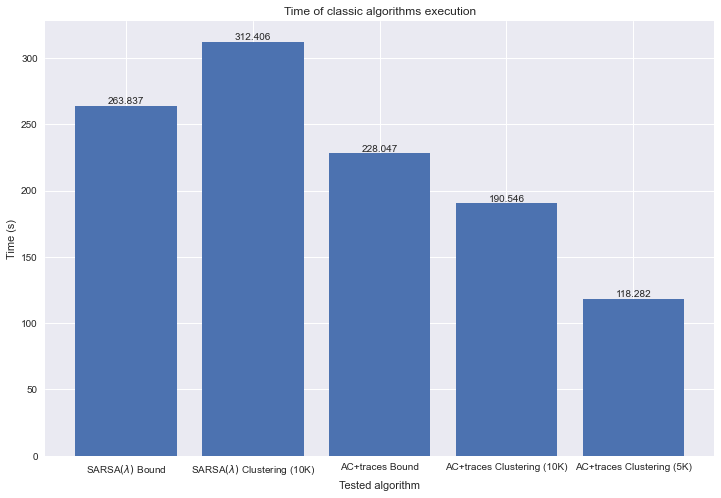

In [54]:
times_classic = [t_sl_bound, t_sl_clust_10, t_ac_bound, t_ac_clust_10, t_ac_clust_5]
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(['SARSA$(\lambda)$ Bound', 'SARSA$(\lambda)$ Clustering (10K)', 'AC+traces Bound', 'AC+traces Clustering (10K)', 'AC+traces Clustering (5K)'],
       times_classic)
ax.bar_label(bars)
ax.set_title('Time of classic algorithms execution')
ax.set_xlabel('Tested algorithm')
ax.set_ylabel('Time (s)');

plt.savefig(join(FIGDIR, 'classic', 'Time of classic algorithms execution.png'), dpi=300, bbox_inches='tight')

### Advanced algorithms

In [17]:
class DiscreteToBoxWrapper(gym.ActionWrapper):
    def __init__(self, env, new_action_set):
        super().__init__(env)
        self.new_action_set = new_action_set
        self.action_space = gym.spaces.Box(low=np.array([0, 1]), high=np.array([1, 5.999]))
        
    def action(self, box_act):
        if box_act[0] < 0.5:
            action = self.new_action_set[0]
        else:
            action = self.new_action_set[int(np.floor(box_act[1]))]
        return action
    
class ReducedDimension(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self._observation_space = gym.spaces.Box(shape=(8,), low=-2.0, high=2.0)
    def observation(self, obs):
        return obs[0:8]

#### PPO, EvalCallback

In [18]:
start_time = time.time()
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))))

eval_callback = EvalCallback(slime_env,
                             eval_freq=100_000,
                             n_eval_episodes=100)

ppo_model = PPO('MlpPolicy', slime_env, verbose=0)

ppo_model.learn(100_000, callback=eval_callback);
end_time = time.time()

Eval num_timesteps=100000, episode_reward=0.88 +/- 1.09
Episode length: 576.90 +/- 94.09
New best mean reward!


In [19]:
t_ppo_eval = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ppo_eval))

--- Elapsed time: 148.22693848609924 seconds ---


#### PPO, no EvalCallback

In [20]:
start_time = time.time()
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))))

ppo_model = PPO('MlpPolicy', slime_env, verbose=0)

ppo_model.learn(100_000);
end_time = time.time()

In [21]:
t_ppo = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_ppo))

--- Elapsed time: 132.92537784576416 seconds ---


#### DQN

In [ ]:
start_time = time.time()
slime_env = Monitor(env=SurvivalRewardEnv(ReducedDimension(gym.make('SlimeVolley-v0'))))

dqn_model = DQN('MlpPolicy', slime_env, verbose=1)

dqn_model.learn(100_000);
end_time = time.time()

In [23]:
t_dqn = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_dqn))

--- Elapsed time: 58.821918964385986 seconds ---


#### SAC

In [ ]:
start_time = time.time()
action_table = [[0, 0, 0], # NOOP
                [1, 0, 0], # LEFT (forward)
                [1, 0, 1], # UPLEFT (forward jump)
                [0, 0, 1], # UP (jump)
                [0, 1, 1], # UPRIGHT (backward jump)
                [0, 1, 0]] # RIGHT (backward)


slime_env = Monitor(env=SurvivalRewardEnv(DiscreteToBoxWrapper(ReducedDimension(gym.make('SlimeVolley-v0')), action_table)))

model = SAC('MlpPolicy', slime_env, verbose=1)

model.learn(10_000);
end_time = time.time()

In [25]:
t_sac = end_time - start_time
print("--- Elapsed time: %s seconds ---" % (t_sac))

--- Elapsed time: 221.9651234149933 seconds ---


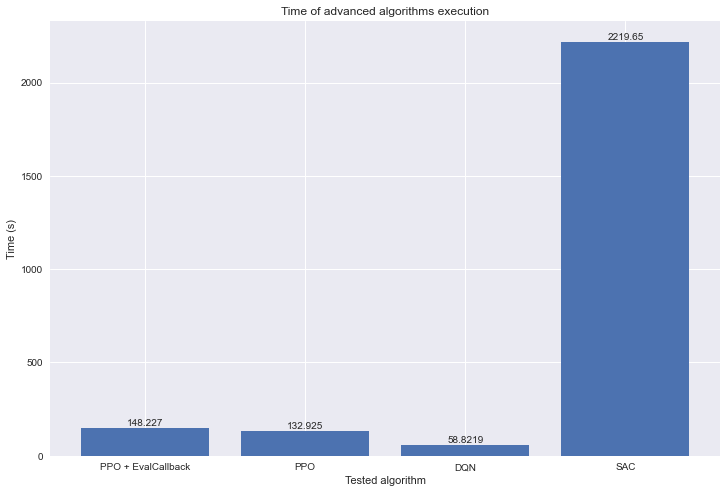

In [53]:
times_advanced = [t_ppo_eval, t_ppo, t_dqn, t_sac*10]
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(['PPO + EvalCallback', 'PPO', 'DQN', 'SAC'], times_advanced)
ax.bar_label(bars)
ax.set_title('Time of advanced algorithms execution')
ax.set_xlabel('Tested algorithm')
ax.set_ylabel('Time (s)');

plt.savefig(join(FIGDIR, 'advanced', 'Time of advanced algorithms execution.png'), dpi=300, bbox_inches='tight')